# Classification of Newsgroups by Text

## Newsgroups Data

We will take a look at some of the twenty newsgroups dataset, another common dataset for classification.

More specifically, it is a list of emails within 20 different newsgroups. We will just focus on a few categories in particular. 

There will most likely be some difficulties or misclassification between emails in `atheism` and `religion` as well as between `comp.graphics` and `space`. Let's see...

In [1]:
from sklearn.datasets import fetch_20newsgroups

# We will use four of the twenty newsgroups
categories = ['alt.atheism',
              'talk.religion.misc',
              'comp.graphics',
              'sci.space']

twenty_train_subset = fetch_20newsgroups(subset='train', categories=categories)
twenty_test_subset = fetch_20newsgroups(subset='test', categories=categories)

Now we have lists of messages (as strings) in the `.data` members.

In [2]:
twenty_train_subset.data[0:2]

[u"From: rych@festival.ed.ac.uk (R Hawkes)\nSubject: 3DS: Where did all the texture rules go?\nLines: 21\n\nHi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych\n\n======================================================================\nRycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\nVirtual Environment Laboratory\nDept. of Psychology\t\t\tTel  : +44 31 650 3426\nUniv. of Edinburgh\t\t\tFax  : +44 31 667 0150\n============

In [3]:
print twenty_train_subset.target[0:2]
print twenty_train_subset.target_names

[1 3]
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## Count Vectorization

Recall how we can generate features from text using the CountVectorizer. We can "fit" a body of text using a count vectorizer, which will give the CountVectorizer a total vocabulary. When we call transform again using the fitted vectorizer, it will return a matrix (sparse matrix) of size `document x vocabulary`, where each element is the frequency of that word.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Turn the text documents into vectors of word frequencies
vectorizer = CountVectorizer()
vectorizer.fit(twenty_train_subset.data) 
X_train = vectorizer.transform(twenty_train_subset.data)

In [10]:
import pandas as pd
pd.DataFrame( X_train.toarray(), columns=vectorizer.get_feature_names())

,00,000,0000,00000,000000,000005102000,000021,000062david42,0000vec,0001,...,zwakke,zware,zwarte,zxmkr08,zyeh,zyklon,zyxel,ªl,º_________________________________________________º_____________________º,ºnd
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Again, this makes a matrix of word counts, where each row is a document and each column is the word, the cell matrix[document, word] contains the count of word in document.

We can expand on this by setting the ngram_range. This parameter allows us to set each column not only as one word, but possibly sequences of words.

We can also provide an argument for `stopwords` that will strip out any english style stop words such as "and", "or", "other", etc for words that don't provide significance.

In [11]:
# Include every 1-gram, 2-gram, and 3-gram
vectorizer = CountVectorizer(ngram_range=(1,3),stop_words='english')
vectorizer.fit(twenty_train_subset.data)
X_train = vectorizer.transform(twenty_train_subset.data)

Additionally, we could use a tf-idf representation, which stands for Term Frequency - Inverse Document Frequency.

This value is the product of two intermediate values, the Term Frequency and the Inverse Document Frequency.

The Term Frequency is equivalent to the CountVectorizer features, the number of times or count that a word appear in the document. This is our most basic representation of text.

To establish Inverse Document Frequency, first let's define Document Frequency. This is the percentage of documents that a particular word appears in. For example, the word `the` might appear in 100% of documents, while words like `Syria` would likely have low document frequency. Inverse Document Frequency is simply 1 / Document Frequency (although often the log is also taken).

So tf-idf is Term Frequency * Inverse Document Frequency, or similar to Term Frequency / Document Frequency. The intuition is that words that have high weight are those that appear a lot in this document and/or appear in very few other documents (somehow unique to this document).

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()

# This is short hand for calling fit, and then transform
X_train = vectorizer.fit_transform(twenty_train_subset.data)

In [14]:
pd.DataFrame( X_train.toarray(), columns= vectorizer.get_feature_names() )

,00,000,0000,00000,000000,000005102000,000021,000062david42,0000vec,0001,...,zwakke,zware,zwarte,zxmkr08,zyeh,zyklon,zyxel,ªl,º_________________________________________________º_____________________º,ºnd
0,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0.000000,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can put this together with our other tricks as well.

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
X_train = vectorizer.fit_transform(twenty_train_subset.data)

For computational ease, let's just look at single word patterns

In [17]:
vectorizer = TfidfVectorizer(stop_words='english') 
X_train = vectorizer.fit_transform(twenty_train_subset.data)

# Exercise - Naive Bayes vs. Decision Trees

We originally reviewed the CountVectorizer concept during our exploration of Naive Bayes. This time, we'll use a tf-idf vectorizer to create our X_train matrix, and compare the performance of Naive Bayes and Decision Trees.


1. Using Naive Bayes, what is your cross validation score on the training data (5 fold using StratifiedShuffleSplit) with a tf-idf matrix?
2. What is your score on the test set when you fit on the entire training set using Naive Bayes?
3. With a similar setup, how well do decision trees perform on training and test? Try comparing the performance of the trees with various max_depth.


**Notes:**
* Using MultinomialNB may provide the best results when creating a Naive Bayes model.
* Note, you will have to define y_train, X_test, and y_test variables.
* You will also have to `transform` the data into a tf-idf matrix for the test set (**Don't call fit again! Remember that `fit` is run on the training set to get a total vocabulary. Once we have this vocabulary, we run transform on new data to transform the known words**)
* Remember not to contaminate your training and test sets. Ideally, the test set should be looked at once at the end. Otherwise, you could end up fitting to the test set.


In [35]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

In [33]:
# Set up data
vectorizer = TfidfVectorizer(stop_words='english') 

vectorizer.fit(twenty_train_subset.data)
X_train = vectorizer.transform(twenty_train_subset.data)
y_train = twenty_train_subset.target


X_test  = vectorizer.transform( twenty_test_subset.data )
y_test  = twenty_test_subset.target

In [36]:
# Multinomial Version
model_nb = MultinomialNB()
model_nb.fit(X_train,y_train)
print "TrainScore:",np.mean(cross_val_score(model_nb,X_train,y_train,
                                            cv=StratifiedShuffleSplit(y_train,5)))
print "TestScore:", model_nb.score(X_test,y_test)

TrainScore: 0.920588235294
TestScore: 0.875092387288


In [38]:
# DTree Version
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
print "TrainScore:",np.mean(cross_val_score(model_dt,X_train,y_train,
                                            cv=StratifiedShuffleSplit(y_train,5)))
print "TestScore:", model_dt.score(X_test,y_test)

TrainScore: 0.81862745098
TestScore: 0.70214338507


# Bagging (Bootstrap Aggregation)

Let's explore how bootstrap aggregation can give us stronger results.

Bagging tends to work well when the base classifiers (weak learners) have a low bias but high variance. By averaging the predictions over these base classifiers, we can reduce the overall variance of the final predictions.

In [52]:
from sklearn.ensemble import BaggingClassifier

# Let's view the arguments in the model
# By default, DecisionTreeClassifier used, 
#  but can also use any base classifier


model_bag = BaggingClassifier(   )   

In [53]:
model_bag.fit(X_train,y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0)

In [54]:
model_bag.score(X_train,y_train)
model_bag.score(X_test,y_test) 

0.74722838137472281

# Exercise - Bagging

* How does bagging compare to a base decision tree classifier with 1, 5, 10, 20, and 30 estimators on the training set? 
* How about on the testing set?
* Plot the improvements on both training and testing sets

If you finish early, feel free to build a bagging ensemble using a different base classifier, such as NaiveBayes or SVM. You may see that SVM does poorly with a default rbf kernel.

In [61]:
n_est = [1,5,10,20,30,50]

train_res, test_res = [], []

for i in n_est:
    print i
    
    model_bag = BaggingClassifier(base_estimator=svm.SVC() 
    model_bag.fit(X_train,y_train)
    train_res.append(model_bag.score(X_train,y_train))
    test_res.append(model_bag.score(X_test,y_test))

1
5
10
20
30
50


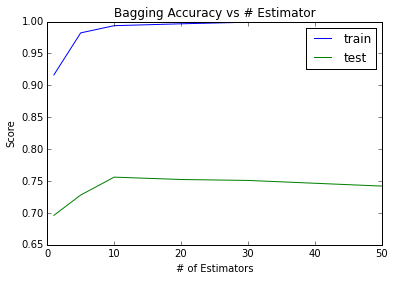

In [63]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(n_est,train_res,label="train")
plt.plot(n_est,test_res, label="test" ) 
plt.xlabel("# of Estimators"), plt.ylabel("Score"), plt.title("Bagging Accuracy vs # Estimator")
plt.legend()

Bagging works very well when the base classifier has a low bias but a high variance.

------
# Random Forests

Random Forests are very popular ensemble classifiers. They are relatively simple to use (very few parameters to set and easy to avoid overfitting). 

The only parameter we are really worried about is the number of trees we want to create - n_estimators in sklearn.

In [65]:
from sklearn.ensemble import RandomForestClassifier

# Default # of vars is sqrt(features)
model_rf = RandomForestClassifier()

We can use predict using our 20-newsgroup dataset above

In [66]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
model_rf.score(X_train,y_train)

0.99508357915437562

We can access the results and parameters of each individual estimator in the random forest through `estimators_`

In [72]:
model_rf.estimators_[0:2]

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             random_state=591477841, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             random_state=1521646388, splitter='best')]

Random Forests can quantify the importance of features. Unlike with logistic regression, we don't have coeffcients that tell us relative impact. But we can keep track of what features give us the best splits.

In [73]:
# This prints the top 10 most important features
print sorted(zip(model_rf.feature_importances_, 
                 vectorizer.get_feature_names()), 
             reverse=True)[:20]

[(0.014357010133987014, u'space'), (0.012158020805175331, u'nasa'), (0.011401028761047831, u'christian'), (0.0098207943619235977, u'writes'), (0.0089695826037428823, u'moon'), (0.0084204948430040959, u'file'), (0.0079924041564997782, u'keith'), (0.0079806783417498313, u'launch'), (0.0078274256240183863, u'looking'), (0.0076880337595739657, u'access'), (0.007435626854264593, u'political'), (0.0068661468518484686, u'say'), (0.0067547888254878997, u'god'), (0.0060847947468401584, u'orbit'), (0.0060524954430212722, u'image'), (0.0059407654127502322, u'atheists'), (0.0054410337013916701, u'digex'), (0.0053384400199401431, u'toronto'), (0.0051268680343381692, u'atheism'), (0.0051179307653781477, u'color')]


# Exercise - Random Forest Estimator Size

* Compare training vs testing performance as you increase the number of estimators (i.e. from 1 - 100 for instance). Plotting will help visualize this.
* In addition, anecdotally compare the performance to that of bagged trees.

Extra: If you finish early, look at the top feature importances for a random forest. Is this similar to the feature importances coming out of a bagged model? Since the BaggingClassifier is generic and does not have a feature\_importances\_ attribute, you may need to roll your own baggingclassifier (i.e. generate your own function to bootstrap samples as well as create decision trees through a for loop, while accessing the feature\_importances\_ of each individual tree)

In [82]:
X_train[np.random.choice(range(X_train.shape[0]),X_train.shape[0]),:].copy()


<2034x33815 sparse matrix of type '<type 'numpy.float64'>'
	with 229714 stored elements in Compressed Sparse Row format>

For ensemble methods, we would like our base classifiers to be *better than random*, as well as *uncorrelated*.

Bagging reduces variance by averaging over many trees. Random forests purposefully add "randomness" through the random features and decreases correlations of these trees. Think of random forest as an improved bagging method.

-----
# Boosting

Adaboost is a boosting implementation by Freund and Schapire that fit a sequence of weak learners. Each step improves upon the last one by overweighting misclassified samples and underweighting correct samples. The weak learners are also given weights based on their error rates.

There are many components in AdaBoost--Let's see how they function.

In [83]:
from sklearn.ensemble import AdaBoostClassifier

In [84]:
# Default decision tree classifier
#  Notice the learning rate
model_boost = AdaBoostClassifier()

SAMME works off of discrete misclassification errors, while SAMME.R uses the predicted probabilities to reweight the samples and base classifiers.

In [85]:
model_boost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [87]:
model_boost.score(X_train,y_train)
model_boost.score(X_test,y_test) 

0.7464892830746489

Boosting tends to perform better when the base classifier has a high bias but low variance.

I.e. Random forest works well with **OVERFIT** models, while Boosting works well with **UNDERFIT** models.

# Exercise - Stumps vs. Dense Trees

Remember that in order for ensemble learners to work well, they require that the base classifiers are better than random guessing, and tend to get 'different questions wrong'. 

Boosting often does surprisingly well when using decision tree stumps (i.e. Decision Tree Classifiers with depth=1).

Create a plot showing in sample and out of sample performance for an adaboost ensemble classifier that uses base_estimator as Decision Tree Classifiers with max depth = 1 and 10, as you increase the number of estimators.

The x-axis should be n_estimators while y-axis is the score (or error = 1 - score). There should be two lines, one for stump and 1 for 10 node trees.

Warning: Make sure your code works correctly--this can take time! I encourage you to try printing out diagnostics too to help you see that it is working.

Also, just using stumps, observe the performance in and out of sample as you increase the n_estimators from 1 to 100. You may want to test various ranges, rather than every number between 1 and 100.

If you finish early, feel free to play around with the GBDT (Gradient Boosted Decision Tree), aka GBT (Gradient Boosted Tree), aka GBM (Gradient Boosted Model) within sklearn. [GBDT](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)

Gradient boosting can be thought of as a generic form of boosting that can take in any differentiable loss function.